ЗАДАНИЕ.
В этом задании вам необходимо использовать набор данных ad.csv.
1) Датасет содежит 2 столбца: объявление (A/B) и действие (0/1).
2) Вам необходимо сформулировать гипотезу, провести ее проверку (пользуясь
классическим подходом) и ответить на вопрос какое из объявлений лучше.


Контекст задачи.
Команда ux-дизайнеров работает над улучшением рекламного баннера. Конверсия текущего объявления составляет 30%. Цель - достичь показателя конверсии 40%, т.е. новый баннер можно будет считать удачным, если конверсия повысится до 40%.

Формулируем гипотезы.
Н0: p(A) = p(B) # коэффициент конверсии А равен коэффициенту конверсии В
Н1: p(A) ≠ p(B) # коэффициент конверсии А не равен коэффициенту конверсии В

In [ ]:
ɑ = 0.05 #критерий значимости объявляем равным 5%. Это значит, что если вероятность наблюдения за результатом (p-значением) ниже ɑ, то гипотеза Н0 отвергается.

In [ ]:
# импортируем все библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns


In [ ]:
# загружаем датасет в виде датафрейма

df = pd.read_csv('ad.csv')
df.head()

,ad_id,action
0,B,1
1,B,1
2,A,0
3,B,0
4,A,1


Описание набора данных
А - контрольная группа
В - тестовая группа
action: 0 - не было клика по объявлению
        1 - был клик по объявлению

In [ ]:
# проверяем, сколько было просмотров у каждого объявления

df['ad_id'].value_counts()

B    1000
A    1000
Name: ad_id, dtype: int64

In [ ]:
# смотрим, сколько было кликов по каждому объявлению

summary_df = pd.crosstab(df['ad_id'], df['action'])
summary_df

action,0,1
ad_id,,
A,696,304
B,628,372


Вычисляем базовые статистики по каждой группе: среднее, стандартное отклонение и стандартную ошибку среднего

In [ ]:
statistics = df.groupby('ad_id')

std_p = lambda x: np.std(x,)  # Вычисляем стандартное отклонение
se_p = lambda x: stats.sem(x)  # Вычисляем стандартную ошибку среднего

statistics = statistics.agg([np.mean, std_p, se_p])
statistics.columns = ['average', 'std_p', 'se_p']
statistics['action'] = summary_df[1]
statistics

,average,std_p,se_p,action
ad_id,,,,
A,0.304,0.459983,0.014553,304
B,0.372,0.483338,0.015292,372


Промежуточный вывод:
Дизайн рекламы В лучше, чем А (коэффициент конверсии А выше В)
 

Строим визуализацию

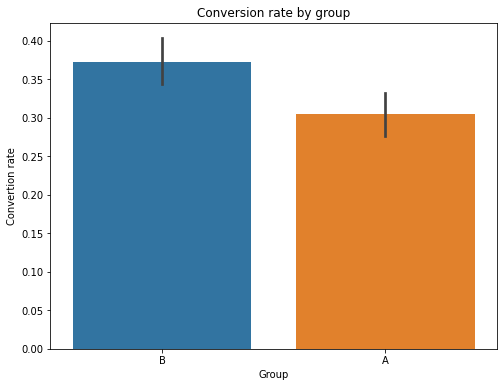

In [ ]:
plt.figure(figsize=(8,6))

sns.barplot(x = df['ad_id'], y = df['action'])
plt.title('Conversion rate by group')
plt.xlabel('Group')
plt.ylabel('Convertion rate');

Можно ли принять, что разница коэффициентов конверсии А и В статистически значима? То есть можем ли мы быть уверены, что разница, которую мы наблюдаем, не случайна?

Проверяем гипотезу.
Используем критерий Z-статистики для конверсии

In [ ]:
# импортируем объект stats.proportion, который позволяет считать пропорции, из библиотеки statsmodels 

from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [ ]:
# выделяем явно группы: контрольная А и тестовая В

control_results = df[df['ad_id'] == 'A']['action']
test_results = df[df['ad_id'] == 'B']['action']

Статистический критерий вернет нам значение p-value, которое позволит оценить, есть ли статистическая значимость в разнице конверсий, которую показывавет наш эксперимент.

Вычисляем p-value.

Передаем функции proportions_ztest следующие параметры:
1) кол-во кликов в каждой группе
2) кол-во просмотров

In [ ]:
nobs = [control_results.count(), test_results.count()]  # кол-во просмотров в каждой группе
successes = [control_results.sum(), test_results.sum()]  # кол-во кликов в каждой группе

In [ ]:
z_stat, pval = proportions_ztest(successes, nobs)
print('z-statistic:', z_stat)
print('p-value:', pval)

z-statistic: -3.2144492244084213
p-value: 0.0013069502732125403


In [ ]:
print(pval < ɑ)  # сравниваем p-value с критерием значимости

True


Промежуточный вывод:    
Т.к. p-value < 0.05, то отклоняем нулевую гипотезу. Новый дизайн рекламы работал значительно иначе, чем старый.

Для расчета доверительных интервалов воспользуемся методом proportion_confint

In [ ]:
(lower_con, lower_test), (upper_con, upper_test) = proportion_confint(successes, nobs = nobs, alpha = ɑ)
print('Доверительный интервал для контрольной группы А:', lower_con, ' - ', upper_con)
print('Доверительный интервал для тестовой группы В:', lower_test, ' - ', upper_test)

Доверительный интервал для контрольной группы А: 0.2754905064387712  -  0.3325094935612288
Доверительный интервал для тестовой группы В: 0.3420429266473629  -  0.4019570733526371


Промежуточный вывод:      
Применив новый дизайн объявления В, можем ожидать повышения конверсии до 40%.

Итог:     
В ходе АВ-тестирования контрольного и тестового вариантов рекламного баннера выявлено, что вариант В имеет больший коэффициент конверсии. Внедрение нового дизайна объявления может повысить коэффициент конверсии до 40%.